## FIN_GAN

Epoch [100/5000] - D Loss: 0.8953, G Loss: 1.2698
Epoch [200/5000] - D Loss: 1.5307, G Loss: 1.1676
Epoch [300/5000] - D Loss: 1.3822, G Loss: 0.7025
Epoch [400/5000] - D Loss: 1.3864, G Loss: 0.6893
Epoch [500/5000] - D Loss: 1.3887, G Loss: 0.6840
Epoch [600/5000] - D Loss: 1.3842, G Loss: 0.6828
Epoch [700/5000] - D Loss: 1.3805, G Loss: 0.6917
Epoch [800/5000] - D Loss: 1.3939, G Loss: 0.6927
Epoch [900/5000] - D Loss: 1.3879, G Loss: 0.6971
Epoch [1000/5000] - D Loss: 1.3835, G Loss: 0.7013
Epoch [1100/5000] - D Loss: 1.3899, G Loss: 0.6922
Epoch [1200/5000] - D Loss: 1.3885, G Loss: 0.6814
Epoch [1300/5000] - D Loss: 1.3850, G Loss: 0.6942
Epoch [1400/5000] - D Loss: 1.3864, G Loss: 0.6948
Epoch [1500/5000] - D Loss: 1.3846, G Loss: 0.6955
Epoch [1600/5000] - D Loss: 1.3879, G Loss: 0.6869
Epoch [1700/5000] - D Loss: 1.3823, G Loss: 0.7052
Epoch [1800/5000] - D Loss: 1.3820, G Loss: 0.6904
Epoch [1900/5000] - D Loss: 1.3778, G Loss: 0.7025
Epoch [2000/5000] - D Loss: 1.4067, G Lo

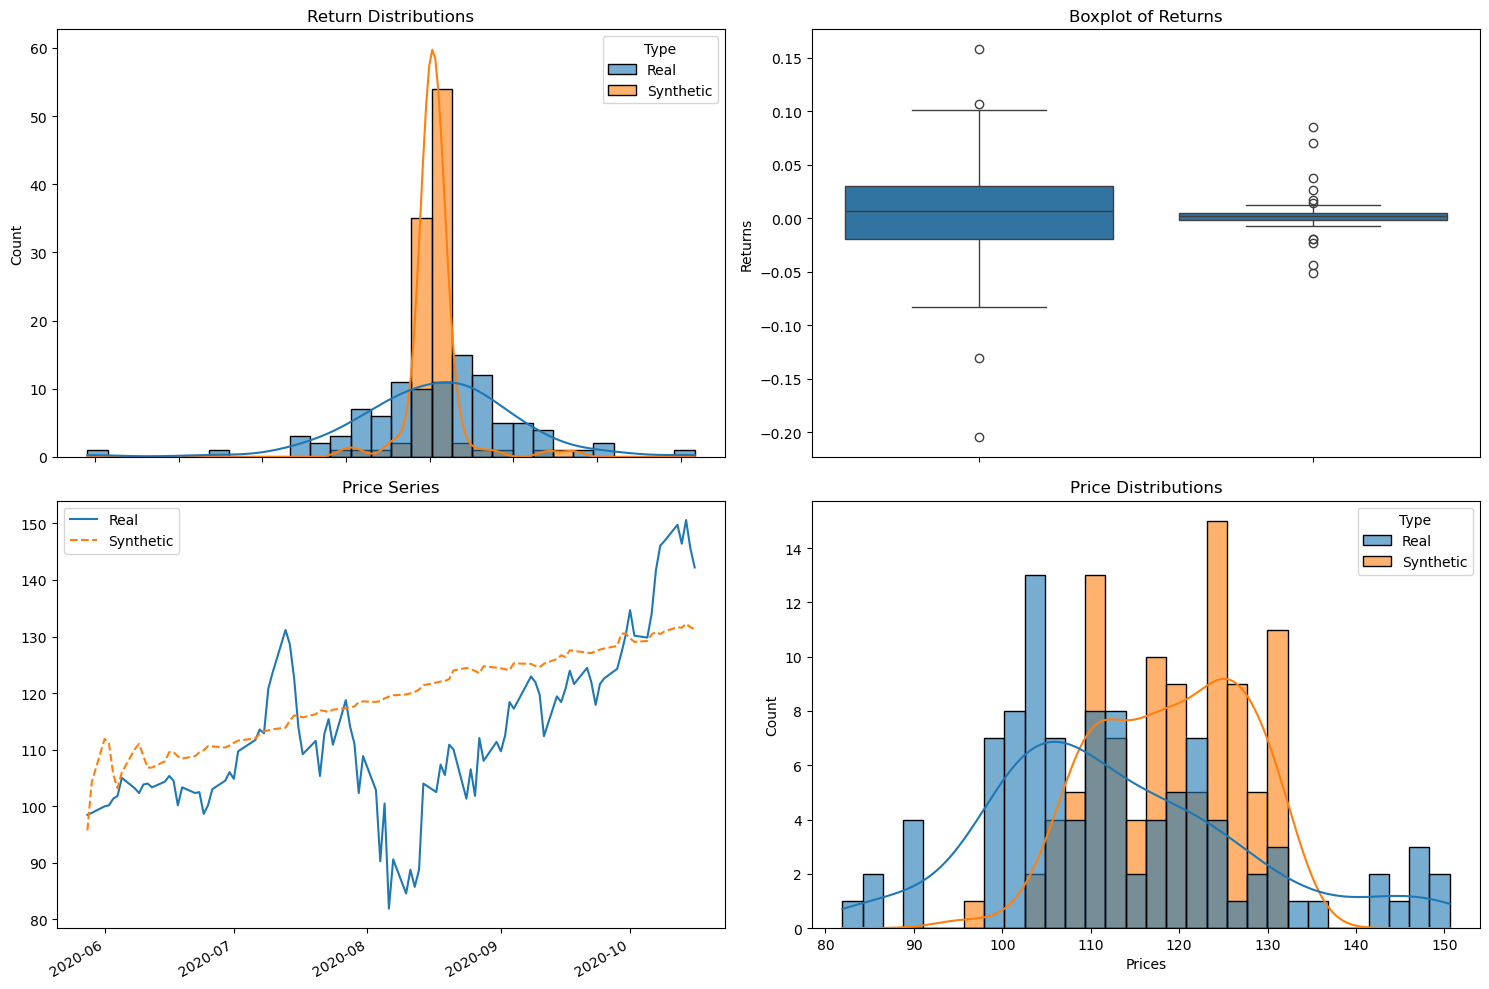


Statistics:
           count      mean       std       min       25%       50%       75%  \
Type                                                                           
Real       100.0  0.003521  0.048509 -0.204567 -0.019606  0.006974  0.030337   
Synthetic  100.0  0.002723  0.014850 -0.050687 -0.001289  0.001887  0.004937   

                max  
Type                 
Real       0.158454  
Synthetic  0.085408  

KS Test: stat = 0.4000, p = 0.0000
T-test (Welch's): stat = 0.1574, p = 0.8752


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from pathlib import Path

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------
# 1. Load and preprocess stock data
# --------------------------------------------
def load_stock_data(file_name="nvidia_2020_2021.csv"):
    base_path = Path.cwd()
    file_path = base_path / "data" / file_name

    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found. Please pull the repo with the data folder.")

    df = pd.read_csv(file_path, header=[0, 1], index_col=0, parse_dates=True)

    if df.empty or df.isnull().all().all():
        raise ValueError(f"File {file_name} is empty or contains only NaNs.")

    df['log_price'] = np.log(df[('Close', 'NVDA')])
    df['log_return'] = df['log_price'].diff()
    df.dropna(inplace=True)
    dates = df.index.to_list()

    scaler = MinMaxScaler()
    scaled_returns = scaler.fit_transform(df[['log_return']])
    return scaled_returns, dates, scaler

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# --------------------------------------------
# 2. Define Fin-GAN (LSTM-based GAN)
# --------------------------------------------
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h).mean(dim=1)

# --------------------------------------------
# 3. Plot & Evaluation
# --------------------------------------------
def plot_and_analyze(real_seq_tensor, synthetic_seq_np, scaler, plot_dates):
    real_seq = real_seq_tensor[0].cpu().numpy()  # shape (seq_len, 1)
    denorm_real = scaler.inverse_transform(real_seq)  # still (seq_len, 1)
    denorm_fake = scaler.inverse_transform(synthetic_seq_np[0])  # shape (seq_len, 1)

    def returns_to_prices(returns):
        log_prices = np.cumsum(returns.ravel())
        return np.exp(log_prices) * 100

    real_prices = returns_to_prices(denorm_real)
    fake_prices = returns_to_prices(denorm_fake)

    # Flatten all arrays for DataFrame columns
    denorm_real_flat = denorm_real.ravel()
    denorm_fake_flat = denorm_fake.ravel()
    real_prices_flat = real_prices.ravel()
    fake_prices_flat = fake_prices.ravel()

    # Make sure date list length matches total rows (real + synthetic)
    dates_real = plot_dates[:len(denorm_real_flat)]
    dates_synthetic = dates_real  # Just reuse the same dates for synthetic
    dates_combined = dates_real + dates_synthetic

    df = pd.DataFrame({
        'Returns': np.concatenate([denorm_real_flat, denorm_fake_flat]),
        'Prices': np.concatenate([real_prices_flat, fake_prices_flat]),
        'Type': ['Real'] * len(denorm_real_flat) + ['Synthetic'] * len(denorm_fake_flat),
        'Date': dates_combined
    })

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Returns', hue='Type', kde=True, bins=30, alpha=0.6)
    plt.title("Return Distributions")

    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Type', y='Returns')
    plt.title("Boxplot of Returns")

    plt.subplot(2, 2, 3)
    plt.plot(df[df['Type'] == 'Real']['Date'], df[df['Type'] == 'Real']['Prices'], label='Real')
    plt.plot(df[df['Type'] == 'Synthetic']['Date'], df[df['Type'] == 'Synthetic']['Prices'], label='Synthetic', linestyle='--')
    plt.title("Price Series")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.legend()

    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='Prices', hue='Type', kde=True, bins=30, alpha=0.6)
    plt.title("Price Distributions")

    plt.tight_layout()
    plt.show()

    print("\nStatistics:")
    print(df.groupby('Type')['Returns'].describe())

    ks_stat, ks_p = stats.ks_2samp(df[df['Type'] == 'Real']['Returns'], df[df['Type'] == 'Synthetic']['Returns'])
    print(f"\nKS Test: stat = {ks_stat:.4f}, p = {ks_p:.4f}")

    t_stat, t_p = stats.ttest_ind(df[df['Type'] == 'Real']['Returns'], df[df['Type'] == 'Synthetic']['Returns'], equal_var=False)
    print(f"T-test (Welch's): stat = {t_stat:.4f}, p = {t_p:.4f}")

# --------------------------------------------
# 4. Train Fin-GAN
# --------------------------------------------
if __name__ == "__main__":
    input_dim = 1
    hidden_dim = 64
    output_dim = 1
    seq_len = 100
    batch_size = 64
    epochs = 5000
    lr = 0.0002

    data, dates, scaler = load_stock_data()
    plot_dates = dates[-(len(data) - seq_len):]  # dates aligned with sequences
    sequences = create_sequences(data, seq_len)
    sequences = torch.tensor(sequences, dtype=torch.float32).to(device)

    generator = Generator(input_dim, hidden_dim, output_dim).to(device)
    discriminator = Discriminator(input_dim, hidden_dim).to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        for i in range(0, len(sequences), batch_size):
            real_seq = sequences[i:i+batch_size]
            batch_size_curr = real_seq.size(0)

            # Discriminator
            z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
            fake_seq = generator(z)
            d_real = discriminator(real_seq)
            d_fake = discriminator(fake_seq.detach())

            d_loss = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Generator
            d_fake = discriminator(fake_seq)
            g_loss = bce(d_fake, torch.ones_like(d_fake))
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # --------------------------------------------
    # 5. Generate and plot synthetic sequence
    # --------------------------------------------
    generator.eval()
    z = torch.randn(1, seq_len, input_dim).to(device)
    synthetic_seq = generator(z).detach().cpu().numpy()

    plot_and_analyze(sequences, synthetic_seq, scaler, plot_dates)


/tmp/ipykernel_2540820/3214399676.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Returns',


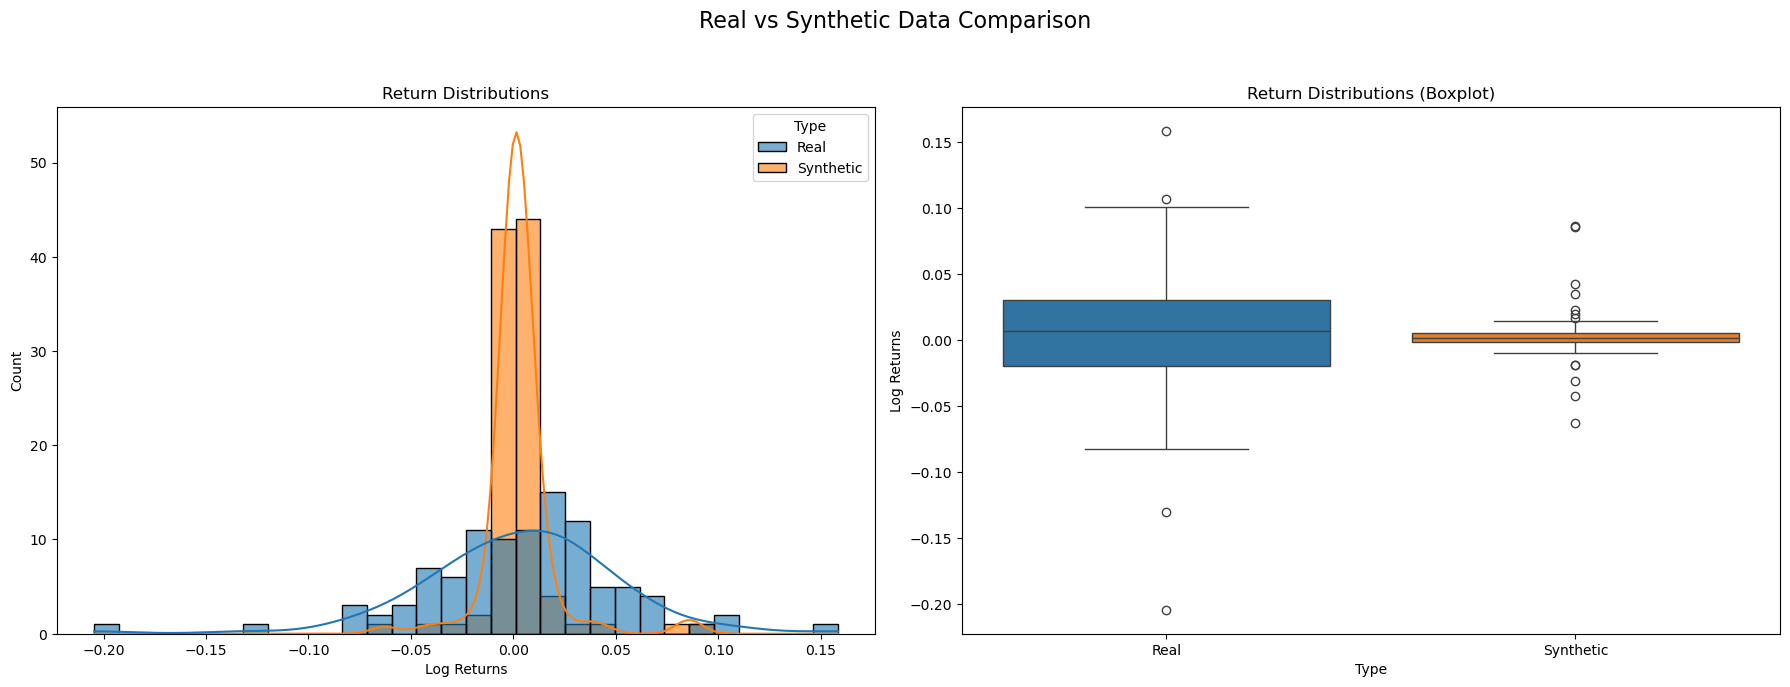


BASIC STATISTICS COMPARISON
       Real Returns  Synthetic Returns
count    100.000000         100.000000
mean       0.003521           0.002866
std        0.048509           0.016712
min       -0.204567          -0.062809
25%       -0.019606          -0.001194
50%        0.006974           0.001534
75%        0.030337           0.005418
max        0.158454           0.086352

STATISTICAL TESTS

Kolmogorov-Smirnov Test:
  Statistic: 0.3900
  p-value: 0.0000

T-test (Welch's):
  Statistic: 0.1278
  p-value: 0.8985


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_and_analyze(real_sequences, synthetic_returns, scaler):
    """
    Generate the 4 requested plots PLUS statistical comparisons
    """
    # Inverse transform real returns
    real_returns = scaler.inverse_transform(real_sequences[0].cpu().numpy())
    
    # Convert returns to prices
    def returns_to_prices(returns):
        log_prices = np.cumsum(returns)
        return np.exp(log_prices)*100   # Using 100 as base price
    
    real_prices = returns_to_prices(real_returns)
    synthetic_prices = returns_to_prices(synthetic_returns)
    
    # Create DataFrames
    df = pd.DataFrame({
        'Returns': np.concatenate([real_returns.flatten(), synthetic_returns.flatten()]),
        'Prices': np.concatenate([real_prices.flatten(), synthetic_prices.flatten()]),
        'Type': ['Real']*len(real_returns) + ['Synthetic']*len(synthetic_returns)
    })
    
    # ======================
    # 1. Generate the Plots
    # ======================
    plt.figure(figsize=(18, 12))
    plt.suptitle('Real vs Synthetic Data Comparison', y=1.02, fontsize=16)
    
    # Plot 1: Return distributions (histogram)
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Returns', hue='Type', 
                kde=True, bins=30, alpha=0.6, 
                palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions')
    plt.xlabel('Log Returns')
    plt.ylabel('Count')
    
    # Plot 2: Return distributions (boxplot)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Type', y='Returns', 
               palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions (Boxplot)')
    plt.ylabel('Log Returns')
    
    # # Plot 3: Price series comparison
    # plt.subplot(2, 2, 3)
    # plt.plot(real_prices, label='Real', color='#1f77b4')
    # plt.plot(synthetic_prices, label='Synthetic', 
    #          linestyle='--', color='#ff7f0e')
    # plt.title('Price Series Comparison')
    # plt.xlabel('Time Steps')
    # plt.ylabel('Price ($)')
    # plt.legend()
    # plt.grid(True)
    
    # # Plot 4: Price distributions
    # plt.subplot(2, 2, 4)
    # sns.histplot(data=df, x='Prices', hue='Type', 
    #             kde=True, bins=30, alpha=0.6,
    #             palette=['#1f77b4', '#ff7f0e'])
    # plt.title('Price Distributions')
    # plt.xlabel('Price ($)')
    # plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # ===========================
    # 2. Statistical Comparisons
    # ===========================
    print("\n" + "="*80)
    print("BASIC STATISTICS COMPARISON")
    print("="*80)
    
    # Calculate basic statistics
    stats_df = pd.DataFrame({
        'Real Returns': df[df['Type']=='Real']['Returns'].describe(),
        'Synthetic Returns': df[df['Type']=='Synthetic']['Returns'].describe()
    })
    print(stats_df)
    
    print("\n" + "="*80)
    print("STATISTICAL TESTS")
    print("="*80)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(
        df[df['Type']=='Real']['Returns'],
        df[df['Type']=='Synthetic']['Returns']
    )
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_stat:.4f}")
    print(f"  p-value: {ks_p:.4f}")
    
    # T-test
    t_stat, t_p = stats.ttest_ind(
        df[df['Type']=='Real']['Returns'],
        df[df['Type']=='Synthetic']['Returns'],
        equal_var=False  # Welch's t-test
    )
    print(f"\nT-test (Welch's):")
    print(f"  Statistic: {t_stat:.4f}")
    print(f"  p-value: {t_p:.4f}")

# Usage with your existing code:
if __name__ == "__main__":
    # After your training code...
    generator.eval()
    z = torch.randn(1, seq_len, input_dim).to(device)
    synthetic_seq = generator(z).detach().cpu().numpy()
    synthetic_returns = scaler.inverse_transform(synthetic_seq[0])
    
    # Generate plots and statistics
    plot_and_analyze(sequences, synthetic_returns, scaler)